In [181]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys

# Standard library imports
import os 
import glob
import numpy as np
import itertools

# Third party imports
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import lightgbm as LGB
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import Lasso,ElasticNet,Ridge
from sklearn.svm import SVR
import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from sklearn.metrics import mean_absolute_error

from tqdm import tqdm
import plotly 
import plotly.express as px
import plotly.graph_objects as go 
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib
from matplotlib import font_manager, rc
import shap

# Dacon plotly 그림 업로드 
pd.options.plotting.backend = 'plotly'
## plotly.io를 import 한 후 renderers 기본값을 꼭 "notebook_connected" 로 설정해주시기 바랍니다.
import plotly.io as pio
pio.renderers.default = "notebook_connected"

#options 
pd.set_option('display.max_columns', None)
matplotlib.rc('font', family='New Gulim') # 한글 설정
matplotlib.rc('axes', unicode_minus=False) # 음수 부호 깨지는거 설정

pd.set_option('max_columns', 50)
pd.set_option('max_rows', 50)

In [182]:
os.chdir('C:/dacon camp/parking_data')

train_raw = pd.read_csv('train.csv')
test_raw = pd.read_csv('test.csv')
age_gender_info_raw = pd.read_csv('age_gender_info.csv')
submission = pd.read_csv('sample_submission.csv')

In [183]:
df_train = train_raw.copy()
df_test = test_raw.copy()
df_gender = age_gender_info_raw.copy()

display("train", df_train.head(3))
display("test", df_test.head(3))

'train'

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
0,C2483,900,아파트,경상북도,국민임대,39.72,134,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
1,C2483,900,아파트,경상북도,국민임대,39.72,15,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
2,C2483,900,아파트,경상북도,국민임대,51.93,385,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0


'test'

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
0,C1072,754,아파트,경기도,국민임대,39.79,116,14.0,H,22830000,189840,0.0,2.0,683.0
1,C1072,754,아파트,경기도,국민임대,46.81,30,14.0,A,36048000,249930,0.0,2.0,683.0
2,C1072,754,아파트,경기도,국민임대,46.90,112,14.0,H,36048000,249930,0.0,2.0,683.0


In [184]:
display('train', df_train.describe())
display('test', df_test.describe())

'train'

,총세대수,전용면적,전용면적별세대수,공가수,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
count,2952.000000,2952.000000,2952.000000,2952.000000,2741.000000,2948.000000,2952.000000,2952.000000
mean,886.661247,44.757215,102.747967,12.921070,0.176578,3.695726,601.668360,559.768293
std,513.540168,31.874280,132.640159,10.778831,0.427408,2.644665,396.407072,433.375027
min,26.000000,12.620000,1.000000,0.000000,0.000000,0.000000,13.000000,13.000000
25%,513.500000,32.100000,14.000000,4.000000,0.000000,2.000000,279.250000,220.000000
50%,779.000000,39.930000,60.000000,11.000000,0.000000,3.000000,517.000000,487.000000
75%,1106.000000,51.562500,144.000000,20.000000,0.000000,4.000000,823.000000,770.000000
max,2568.000000,583.400000,1865.000000,55.000000,3.000000,20.000000,1798.000000,2550.000000


'test'

,총세대수,전용면적,전용면적별세대수,공가수,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
count,1022.000000,1022.000000,1022.000000,1022.000000,980.000000,1022.000000,1022.000000
mean,862.080235,43.706311,100.414873,15.544031,0.136735,4.626223,548.771037
std,536.340894,35.890759,125.997855,11.070140,0.435500,5.414568,342.636703
min,75.000000,9.960000,1.000000,0.000000,0.000000,1.000000,29.000000
25%,488.000000,33.135000,14.000000,6.000000,0.000000,2.000000,286.000000
50%,745.000000,39.720000,60.000000,15.000000,0.000000,3.000000,458.000000
75%,1161.000000,47.400000,140.000000,23.000000,0.000000,5.000000,711.000000
max,2572.000000,583.400000,1341.000000,45.000000,2.000000,50.000000,1696.000000


In [185]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2952 entries, 0 to 2951
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   단지코드                          2952 non-null   object 
 1   총세대수                          2952 non-null   int64  
 2   임대건물구분                        2952 non-null   object 
 3   지역                            2952 non-null   object 
 4   공급유형                          2952 non-null   object 
 5   전용면적                          2952 non-null   float64
 6   전용면적별세대수                      2952 non-null   int64  
 7   공가수                           2952 non-null   float64
 8   자격유형                          2952 non-null   object 
 9   임대보증금                         2383 non-null   object 
 10  임대료                           2383 non-null   object 
 11  도보 10분거리 내 지하철역 수(환승노선 수 반영)  2741 non-null   float64
 12  도보 10분거리 내 버스정류장 수            2948 non-null   float64
 13  단지내

In [186]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1022 entries, 0 to 1021
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   단지코드                          1022 non-null   object 
 1   총세대수                          1022 non-null   int64  
 2   임대건물구분                        1022 non-null   object 
 3   지역                            1022 non-null   object 
 4   공급유형                          1022 non-null   object 
 5   전용면적                          1022 non-null   float64
 6   전용면적별세대수                      1022 non-null   int64  
 7   공가수                           1022 non-null   float64
 8   자격유형                          1020 non-null   object 
 9   임대보증금                         842 non-null    object 
 10  임대료                           842 non-null    object 
 11  도보 10분거리 내 지하철역 수(환승노선 수 반영)  980 non-null    float64
 12  도보 10분거리 내 버스정류장 수            1022 non-null   float64
 13  단지내

# 결측치 처리

In [187]:
# 결측값 확인
display('train NA :', df_train.isnull().sum())
display('test NA :', df_test.isnull().sum())

'train NA :'

단지코드                              0
총세대수                              0
임대건물구분                            0
지역                                0
공급유형                              0
전용면적                              0
전용면적별세대수                          0
공가수                               0
자격유형                              0
임대보증금                           569
임대료                             569
도보 10분거리 내 지하철역 수(환승노선 수 반영)    211
도보 10분거리 내 버스정류장 수                4
단지내주차면수                           0
등록차량수                             0
dtype: int64

'test NA :'

단지코드                              0
총세대수                              0
임대건물구분                            0
지역                                0
공급유형                              0
전용면적                              0
전용면적별세대수                          0
공가수                               0
자격유형                              2
임대보증금                           180
임대료                             180
도보 10분거리 내 지하철역 수(환승노선 수 반영)     42
도보 10분거리 내 버스정류장 수                0
단지내주차면수                           0
dtype: int64

In [188]:
# 임대보증금, 임대료 결측치 확인
df_train.loc[df_train['임대보증금'] == '-', '임대보증금'] = np.nan
df_test.loc[df_test['임대보증금'] == '-', '임대보증금'] = np.nan
df_train['임대보증금'] = df_train['임대보증금'].astype('float')
df_test['임대보증금'] = df_test['임대보증금'].astype('float')

df_train.loc[df_train['임대료'] == '-', '임대료'] = np.nan
df_test.loc[df_test['임대료'] == '-', '임대료'] = np.nan
df_train['임대료'] = df_train['임대료'].astype('float')
df_test['임대료'] = df_test['임대료'].astype('float')

In [189]:
# 임대료, 임대보증금은 0으로 결측치 처리
df_train[['임대료', '임대보증금']] = df_train[['임대료', '임대보증금']].fillna(0).astype('int')
df_test[['임대료', '임대보증금']] = df_test[['임대료', '임대보증금']].fillna(0).astype('int')

In [190]:
# 변수명이 길어서 짧게 변경
df_train.rename(columns={'도보 10분거리 내 지하철역 수(환승노선 수 반영)' : '지하철', '도보 10분거리 내 버스정류장 수' : '버스'}, inplace=True)
df_test.rename(columns={'도보 10분거리 내 지하철역 수(환승노선 수 반영)' : '지하철', '도보 10분거리 내 버스정류장 수' : '버스'}, inplace=True)

# 버스, 지하철 0으로 결측치 처리
df_train[['버스', '지하철']] = df_train[['버스', '지하철']].fillna(0)
df_test[['버스', '지하철']] = df_test[['버스', '지하철']].fillna(0)

In [191]:
df_test[df_test['자격유형'].isnull()] # 단지코드 C2411, C2253의 자격유형에 결측값 존재

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수
196,C2411,962,아파트,경상남도,국민임대,46.90,240,25.0,NaN,71950000,37470,0.0,2.0,840.0
258,C2253,1161,아파트,강원도,영구임대,26.37,745,0.0,NaN,2249000,44770,0.0,2.0,173.0


In [192]:
display(df_test[df_test['단지코드'] == 'C2411']) # 자격유형 A로 보간
display(df_test[df_test['단지코드'] == 'C2253']) # 자격유형 C로 보간

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수
193,C2411,962,아파트,경상남도,국민임대,39.43,56,25.0,A,11992000,100720,0.0,2.0,840.0
194,C2411,962,아파트,경상남도,국민임대,39.72,336,25.0,A,11992000,100720,0.0,2.0,840.0
195,C2411,962,아파트,경상남도,국민임대,39.82,179,25.0,A,11992000,100720,0.0,2.0,840.0
196,C2411,962,아파트,경상남도,국민임대,46.90,240,25.0,NaN,71950000,37470,0.0,2.0,840.0
197,C2411,962,아파트,경상남도,국민임대,51.93,150,25.0,A,21586000,171480,0.0,2.0,840.0


,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수
258,C2253,1161,아파트,강원도,영구임대,26.37,745,0.0,NaN,2249000,44770,0.0,2.0,173.0
259,C2253,1161,아파트,강원도,영구임대,31.32,239,0.0,C,3731000,83020,0.0,2.0,173.0
260,C2253,1161,아파트,강원도,영구임대,31.32,149,0.0,C,3731000,83020,0.0,2.0,173.0
261,C2253,1161,상가,강원도,임대상가,13.77,1,0.0,D,0,0,0.0,2.0,173.0
262,C2253,1161,상가,강원도,임대상가,22.89,1,0.0,D,0,0,0.0,2.0,173.0
263,C2253,1161,상가,강원도,임대상가,22.91,1,0.0,D,0,0,0.0,2.0,173.0
264,C2253,1161,상가,강원도,임대상가,23.79,1,0.0,D,0,0,0.0,2.0,173.0
265,C2253,1161,상가,강원도,임대상가,23.79,1,0.0,D,0,0,0.0,2.0,173.0
266,C2253,1161,상가,강원도,임대상가,23.86,1,0.0,D,0,0,0.0,2.0,173.0
267,C2253,1161,상가,강원도,임대상가,23.86,1,0.0,D,0,0,0.0,2.0,173.0


In [193]:
df_test.loc[(df_test['단지코드'] == 'C2411') & (df_test['자격유형'].isnull()), '자격유형'] = 'A'
df_test.loc[(df_test['단지코드'] == 'C2253') & (df_test['자격유형'].isnull()), '자격유형'] = 'C'

In [194]:
# 중복값 제거
df_train = df_train.drop_duplicates()
df_test = df_test.drop_duplicates()

# 단지코드별 데이터 추출

파베르 님의 코드를 참조했습니다.   
https://dacon.io/competitions/official/235745/codeshare/2851?page=1&dtype=recent

In [195]:
unique_cols = ['총세대수', '지역', '공가수', 
               '지하철',
               '버스',
               '단지내주차면수', '등록차량수'] # 한 세대당 하나의 값만 가지는 변수들

train_agg = df_train.set_index('단지코드')[unique_cols].drop_duplicates()
test_agg = df_test.set_index('단지코드')[[col for col in unique_cols if col!='등록차량수']].drop_duplicates()

display(train_agg.head())
display(test_agg.head())

,총세대수,지역,공가수,지하철,버스,단지내주차면수,등록차량수
단지코드,,,,,,,
C2483,900,경상북도,38.0,0.0,3.0,1425.0,1015.0
C2515,545,경상남도,17.0,0.0,3.0,624.0,205.0
C1407,1216,대전광역시,13.0,1.0,1.0,1285.0,1064.0
C1945,755,경기도,6.0,1.0,3.0,734.0,730.0
C1470,696,전라북도,14.0,0.0,2.0,645.0,553.0


,총세대수,지역,공가수,지하철,버스,단지내주차면수
단지코드,,,,,,
C1072,754,경기도,14.0,0.0,2.0,683.0
C1128,1354,경기도,9.0,0.0,3.0,1216.0
C1456,619,부산광역시,18.0,0.0,16.0,547.0
C1840,593,전라북도,7.0,0.0,3.0,543.0
C1332,1297,경기도,11.0,0.0,2.0,1112.0


In [196]:
df_train.loc[df_train.공급유형.isin(['공공임대(5년)', '공공분양', '공공임대(10년)', '공공임대(분납)']), '공급유형'] = '공공임대(5년/10년/분납/분양)'
df_test.loc[df_test.공급유형.isin(['공공임대(5년)', '공공분양', '공공임대(10년)', '공공임대(분납)']), '공급유형'] = '공공임대(5년/10년/분납/분양)'
df_train.loc[df_train.공급유형.isin(['장기전세', '국민임대']), '공급유형'] = '국민임대/장기전세'
df_test.loc[df_test.공급유형.isin(['장기전세', '국민임대']), '공급유형'] = '국민임대/장기전세'

df_train.loc[df_train.자격유형.isin(['J', 'L', 'K', 'N', 'M', 'O']), '자격유형'] = '행복주택_공급대상'
df_test.loc[df_test.자격유형.isin(['J', 'L', 'K', 'N', 'M', 'O']), '자격유형'] = '행복주택_공급대상'

df_train.loc[df_train.자격유형.isin(['H', 'B', 'E', 'G']), '자격유형'] = '국민임대/장기전세_공급대상'
df_test.loc[df_test.자격유형.isin(['H', 'B', 'E', 'G']), '자격유형'] = '국민임대/장기전세_공급대상'

df_train.loc[df_train.자격유형.isin(['C', 'I', 'F']), '자격유형'] = '영구임대_공급대상'
df_test.loc[df_test.자격유형.isin(['C', 'I', 'F']), '자격유형'] = '영구임대_공급대상'

In [197]:
# assign 함수는 데이터프레임에 변수를 하나 더 생성해주는 것.
# counter라는 변수를 생성하고 1이라는 값을 줌.
def reshape_cat_features(data, cast_col, value_col):
    res = data.drop_duplicates(['단지코드', cast_col]).assign(counter=1).pivot(index='단지코드', columns=cast_col, values=value_col).fillna(0)
    res.columns.name = None
    res = res.rename(columns={col:cast_col+'_'+col for col in res.columns})
    return res

In [198]:
# 훈련 및 시험 데이터 생성
X_train = pd.concat([train_agg,
                       reshape_cat_features(data=df_train, cast_col='임대건물구분', value_col='counter'),
                       reshape_cat_features(data=df_train, cast_col='공급유형', value_col='counter'),
                       reshape_cat_features(data=df_train, cast_col='자격유형', value_col='counter')], axis=1)

X_test = pd.concat([test_agg,
                       reshape_cat_features(data=df_test, cast_col='임대건물구분', value_col='counter'),
                       reshape_cat_features(data=df_test, cast_col='공급유형', value_col='counter'),
                       reshape_cat_features(data=df_test, cast_col='자격유형', value_col='counter')], axis=1)

아래의 코드는 전용면적을 활용한 파생변수를 생성한 것입니다.   
흔들리는 인덕원역님의 코드를 참조했습니다.   
   
https://dacon.io/competitions/official/235745/codeshare/2860?page=1&dtype=recent

In [199]:
X_train = X_train.reset_index().rename(columns={'index':'단지코드'})
X_test = X_test.reset_index().rename(columns={'index':'단지코드'})

# 전용면적
- 전용면적을 10개의 범주로 나누어 해당되는 범위에 포함되는 세대가 있다면 1을 표시하는 변수 생성
    - 집의 면적이 클수록 등록차량수가 많은 인사이트를 도출했기 때문에 해당 변수를 생성

In [200]:
# 모델 성능 더 나빠짐 삭제 필요
df_train['전용면적'] = df_train['전용면적'] //10*10
df_train['전용면적'] = np.where(df_train['전용면적'] > 100, 100, df_train['전용면적'])
df_train['전용면적'] = np.where(df_train['전용면적'] < 15, 15, df_train['전용면적'])

df_train.loc[:,'총전용면적'] = df_train.loc[:,'전용면적'] * df_train.loc[:,'전용면적별세대수']

codes = df_train['단지코드'].unique()
columns = ['단지코드', '총세대수', '지역', '공가수','지하철', '버스', '단지내주차면수']

for order, code in enumerate(codes):
    temp_by_code = df_train.loc[df_train['단지코드']==code].reset_index(drop=True)
    ## 원 계열 값 그냥 가져오기 
    X_train.loc[order, columns] = temp_by_code.loc[0, columns]             
    X_train.loc[order, "총임대가구수"] = temp_by_code['전용면적별세대수'].sum()

X_train["임대비율"] = X_train['총임대가구수'] / X_train['총세대수']
X_train["가구당주차면수"] = X_train['단지내주차면수'] / X_train['총세대수']

# 전용면적 구간화
bins = list(range(10, 101, 10))
bins_label = [str(x)+"이상 "+str(x+10)+"미만" for x in bins]
df_train["전용면적_level"] = pd.cut(df_train["전용면적"], bins, right=False, labels=bins_label[:-1])

df_train['전용면적_level'] = df_train['전용면적_level'].cat.add_categories('100이상')
df_train.loc[df_train['전용면적'] >= 100, '전용면적_level'] = '100이상'

temp = pd.DataFrame(df_train.groupby(['단지코드', '전용면적_level'])['전용면적_level'].count()).rename(columns={'전용면적_level' : 'count'}).reset_index()
temp['전용면적_level'] = temp['전용면적_level'].astype('str')
temp = pd.pivot_table(data=temp, columns='전용면적_level', index='단지코드', values='count').fillna(0).reset_index()

X_train = pd.merge(X_train, temp, how='left', left_on='단지코드', right_on='단지코드')

In [201]:
# 모델 성능 더 나빠짐 삭제 필요
df_test['전용면적'] = df_test['전용면적'] //10*10
df_test['전용면적'] = np.where(df_test['전용면적'] > 100, 100, df_test['전용면적'])
df_test['전용면적'] = np.where(df_test['전용면적'] < 15, 15, df_test['전용면적'])

df_test.loc[:,'총전용면적'] = df_test.loc[:,'전용면적'] * df_test.loc[:,'전용면적별세대수']

codes = df_test['단지코드'].unique()
columns = ['단지코드', '총세대수', '지역', '공가수','지하철', '버스', '단지내주차면수']

for order, code in enumerate(codes):
    temp_by_code = df_test.loc[df_test['단지코드']==code].reset_index(drop=True)
    ## 원 계열 값 그냥 가져오기 
    X_test.loc[order, columns] = temp_by_code.loc[0, columns]             
    X_test.loc[order, "총임대가구수"] = temp_by_code['전용면적별세대수'].sum()

X_test["임대비율"] = X_test['총임대가구수'] / X_test['총세대수']
X_test["가구당주차면수"] = X_test['단지내주차면수'] / X_test['총세대수']

# 전용면적 구간화
bins = list(range(10, 101, 10))
bins_label = [str(x)+"이상 "+str(x+10)+"미만" for x in bins]
df_test["전용면적_level"] = pd.cut(df_test["전용면적"], bins, right=False, labels=bins_label[:-1])

df_test['전용면적_level'] = df_test['전용면적_level'].cat.add_categories('100이상')
df_test.loc[df_test['전용면적'] >= 100, '전용면적_level'] = '100이상'

temp = pd.DataFrame(df_test.groupby(['단지코드', '전용면적_level'])['전용면적_level'].count()).rename(columns={'전용면적_level' : 'count'}).reset_index()
temp['전용면적_level'] = temp['전용면적_level'].astype('str')
temp = pd.pivot_table(data=temp, columns='전용면적_level', index='단지코드', values='count').fillna(0).reset_index()

X_test = pd.merge(X_test, temp, how='left', left_on='단지코드', right_on='단지코드')

# 자격유형별 통계량 생성

- 컨셉 
    - 단지코드별 자격유형이 가장 많은 값을 대표값으로 두고 자격유형에 따른 단지내주차면수 통계량을 생성해서 변수로 사용  (*단지내추자면수가 등록차량수와 높은 상관관계를 보이기 때문에 다양한 파생변수를 생성해보자는 생각에서 시작)
    - 자격유형은 소득분위에 따라 결정이 되므로 임대료와 임대보증금 관련한 통계량들도 생성해보자

In [202]:
# 단지코드별 자격유형의 최빈값을 대표값으로 사용 (Train)
supply_type_codes = {}
for code in list(df_train['단지코드'].unique()):
    supply_type = df_train[df_train['단지코드'] == code]['자격유형'].value_counts().sort_values(ascending=False).index[0]
    supply_type_codes[code] = supply_type

temp = pd.DataFrame(list(supply_type_codes.items()), columns=['단지코드', '자격유형'])
X_train = pd.merge(X_train, temp, how='left', left_on='단지코드', right_on='단지코드')

temp = X_train.groupby(['자격유형'])['단지내주차면수'].agg(['mean', 'median', 'std']).reset_index().fillna(0)
temp = temp.rename(columns={'mean' : '자격유형_주차면수_mean',
                           'median' : '자격유형_주차면수_median',
                           'std' : '자격유형_주차면수_std'})
X_train = pd.merge(X_train, temp, how = 'left', on ='자격유형')

# 자격유형은 소득분위별로 책정이되므로, 임대료, 임대보증금 통계량도 생성해보자.
temp = df_train.groupby(['자격유형'])['임대료'].agg(['mean', 'median', 'std']).fillna(0).reset_index()
temp = temp.rename(columns={'mean' : '자격유형_임대료_mean',
                           'median' : '자격유형_임대료_median',
                           'std' : '자격유형_임대료_std'})
X_train = pd.merge(X_train, temp, how='left', on='자격유형')

temp = df_train.groupby(['자격유형'])['임대보증금'].agg(['mean', 'median', 'std']).fillna(0).reset_index()
temp = temp.rename(columns={'mean' : '자격유형_임대보증금_mean',
                           'median' : '자격유형_임대보증금_median',
                           'std' : '자격유형_임대보증금_std'})
X_train = pd.merge(X_train, temp, how='left', on='자격유형')

In [203]:
# 단지코드별 자격유형의 최빈값을 대표값으로 사용 (Test)
supply_type_codes = {}
for code in list(df_test['단지코드'].unique()):
    supply_type = df_test[df_test['단지코드'] == code]['자격유형'].value_counts().sort_values(ascending=False).index[0]
    supply_type_codes[code] = supply_type

temp = pd.DataFrame(list(supply_type_codes.items()), columns=['단지코드', '자격유형'])
X_test = pd.merge(X_test, temp, how='left', left_on='단지코드', right_on='단지코드')

temp = X_test.groupby(['자격유형'])['단지내주차면수'].agg(['mean', 'median', 'std']).reset_index().fillna(0)
temp = temp.rename(columns={'mean' : '자격유형_주차면수_mean',
                           'median' : '자격유형_주차면수_median',
                           'std' : '자격유형_주차면수_std'})
X_test = pd.merge(X_test, temp, how = 'left', on ='자격유형')

# 자격유형은 소득분위별로 책정이되므로, 임대료, 임대보증금 통계량도 생성해보자.
temp = df_test.groupby(['자격유형'])['임대료'].agg(['mean', 'median', 'std']).fillna(0).reset_index()
temp = temp.rename(columns={'mean' : '자격유형_임대료_mean',
                           'median' : '자격유형_임대료_median',
                           'std' : '자격유형_임대료_std'})
X_test = pd.merge(X_test, temp, how='left', on='자격유형')

temp = df_test.groupby(['자격유형'])['임대보증금'].agg(['mean', 'median', 'std']).fillna(0).reset_index()
temp = temp.rename(columns={'mean' : '자격유형_임대보증금_mean',
                           'median' : '자격유형_임대보증금_median',
                           'std' : '자격유형_임대보증금_std'})
X_test = pd.merge(X_test, temp, how='left', on='자격유형')

In [204]:
X_train.drop(['자격유형'], axis=1, inplace=True)
X_test.drop(['자격유형'], axis=1, inplace=True)

# 공급유형별 통계량 생성
- 컨셉 
    - 단지코드별 공급유형이 가장 많은 값을 대표값으로 두고 자격유형에 따른 단지내주차면수 통계량을 생성해서 변수로 사용  (*단지내추자면수가 등록차량수와 높은 상관관계를 보이기 때문에 다양한 파생변수를 생성해보자는 생각에서 시작)


In [205]:
# 단지코드별 공급유형의 최빈값을 대표값으로 사용 (Train)
supply_type_codes = {}
for code in list(df_train['단지코드'].unique()):
    supply_type = df_train[df_train['단지코드'] == code]['공급유형'].value_counts().sort_values(ascending=False).index[0]
    supply_type_codes[code] = supply_type

temp = pd.DataFrame(list(supply_type_codes.items()), columns=['단지코드', '공급유형'])
X_train = pd.merge(X_train, temp, how='left', left_on='단지코드', right_on='단지코드')

temp = X_train.groupby(['공급유형'])['단지내주차면수'].agg(['mean', 'median', 'std']).reset_index().fillna(0)
temp = temp.rename(columns={'mean' : '공급유형_주차면수_mean',
                           'median' : '공급유형_주차면수_median',
                           'std' : '공급유형_주차면수_std'})
X_train = pd.merge(X_train, temp, how = 'left', on ='공급유형')

In [206]:
# 단지코드별 공급유형의 최빈값을 대표값으로 사용 (Train)
supply_type_codes = {}
for code in list(df_test['단지코드'].unique()):
    supply_type = df_test[df_test['단지코드'] == code]['공급유형'].value_counts().sort_values(ascending=False).index[0]
    supply_type_codes[code] = supply_type

temp = pd.DataFrame(list(supply_type_codes.items()), columns=['단지코드', '공급유형'])
X_test = pd.merge(X_test, temp, how='left', left_on='단지코드', right_on='단지코드')

temp = X_test.groupby(['공급유형'])['단지내주차면수'].agg(['mean', 'median', 'std']).reset_index().fillna(0)
temp = temp.rename(columns={'mean' : '공급유형_주차면수_mean',
                           'median' : '공급유형_주차면수_median',
                           'std' : '공급유형_주차면수_std'})
X_test = pd.merge(X_test, temp, how = 'left', on ='공급유형')

In [207]:
X_train.drop(['공급유형'], axis=1, inplace=True)
X_test.drop(['공급유형'], axis=1, inplace=True)

# 외부 데이터 조인
우리나라 지역별 세대수와 자동차등록수 데이터를 수집했고 이를 활용해보려 했습니다. 결과적으로는 예측 성능이 개선되지는 않았습니다.

In [208]:
# 시도별 등록세대현황 데이터
population_info = pd.read_csv('추가자료/202105_202105_주민등록인구및세대현황_월간.csv', encoding='cp949')

population_info = population_info.iloc[1:, :]
population_info = population_info.reset_index(drop=True)

import re

hanguel = re.compile('[^ㄱ-ㅣ가-힣]')

for i in range(population_info.shape[0]):
    result = hanguel.sub('',population_info.iloc[i,0])
    population_info.iloc[i,0] = result
    
population_info = population_info.iloc[:, [0,2]]
population_info = population_info.rename(columns={'2021년05월_세대수' : '세대수'})

# 시도별 자동차등록수
car_stats = pd.read_excel('추가자료/2021년_05월_자동차_등록자료_통계.xlsx', header=2)
# car_stats = car_stats.iloc[1:18, :]
car_stats = car_stats.iloc[:, [0, 3]]
car_stats = car_stats.rename(columns = {'차종' : '행정구역', 'Unnamed: 3' : '자가용'})
car_stats = car_stats.iloc[2:19, :].reset_index(drop=True)

car_stats.loc[:, '행정구역'] = population_info.loc[:, '행정구역']

# 두 데이터를 합친 데이터 생성
outer_data = pd.merge(population_info, car_stats, how='left', on='행정구역')

import re

number = re.compile('[^0-9]')

for i in range(outer_data.shape[0]):
    result = number.sub('',outer_data.iloc[i,1])
    outer_data.iloc[i,1] = result

outer_data['세대수'] = outer_data['세대수'].astype('int64')
outer_data['자가용'] = outer_data['자가용'].astype('int64')
outer_data = outer_data.rename(columns={'행정구역':'지역'})

X_train = pd.merge(X_train, outer_data, how='left', on='지역')
X_test = pd.merge(X_test, outer_data, how='left', on='지역')

# 클러스터링

In [209]:
# 최적의 n_cluster를 찾아보자.
# 지역을 기준으로 집단을 구분했습니다. (16개의 지역)
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=16, random_state=1127).fit(X_train.drop(['단지코드', '지역', '등록차량수'], axis=1))
X_train['cluster'] = kmeans.predict(X_train.drop(['단지코드', '지역', '등록차량수'], axis=1))
X_test['cluster'] = kmeans.predict(X_test.drop(['단지코드', '지역'], axis=1))

# 변수 전처리

In [210]:
# 임대건물구분_아파트의 값이 모두 1이라 삭제
X_train = X_train.drop(['임대건물구분_아파트'], axis=1)
X_test = X_test.drop(['임대건물구분_아파트'], axis=1)

In [211]:
# 지하철 이상치 제거
X_train.groupby(['지하철'])['총세대수'].count()

지하철
0.0    379
1.0     38
2.0      5
3.0      1
Name: 총세대수, dtype: int64

In [212]:
X_train = X_train[X_train['지하철'] != 3]

In [213]:
# 지역과 지하철 그룹에 따른 등록차량수의 평균, 중위값, 표준편차 변수 생성
encoding_features = ['지역', '지하철']
for f in encoding_features:
    mapping = X_train.groupby([f])['등록차량수'].agg(['mean','median','std'])
    mapping_values = []
    for l in X_train[f].values:
        mapping_values.extend([mapping.loc[l].values])
    bincount = pd.DataFrame(mapping_values, columns = [f+'_mean', f+'_median', f+'_std', ], index = X_train.index)
    X_train = pd.concat([X_train,bincount], axis= 1).drop([f], axis=1)
    
    mapping_values = []
    for l in X_test[f].values:
        mapping_values.extend([mapping.loc[l].values])
    bincount = pd.DataFrame(mapping_values, columns = [f+'_mean', f+'_median', f+'_std', ], index = X_test.index)
    X_test = pd.concat([X_test,bincount], axis= 1).drop([f], axis=1)

In [214]:
# 연속형 변수들
scailing_features = list(X_train.select_dtypes('float').columns)
scailing_features.remove('등록차량수')
display(len(scailing_features))

34

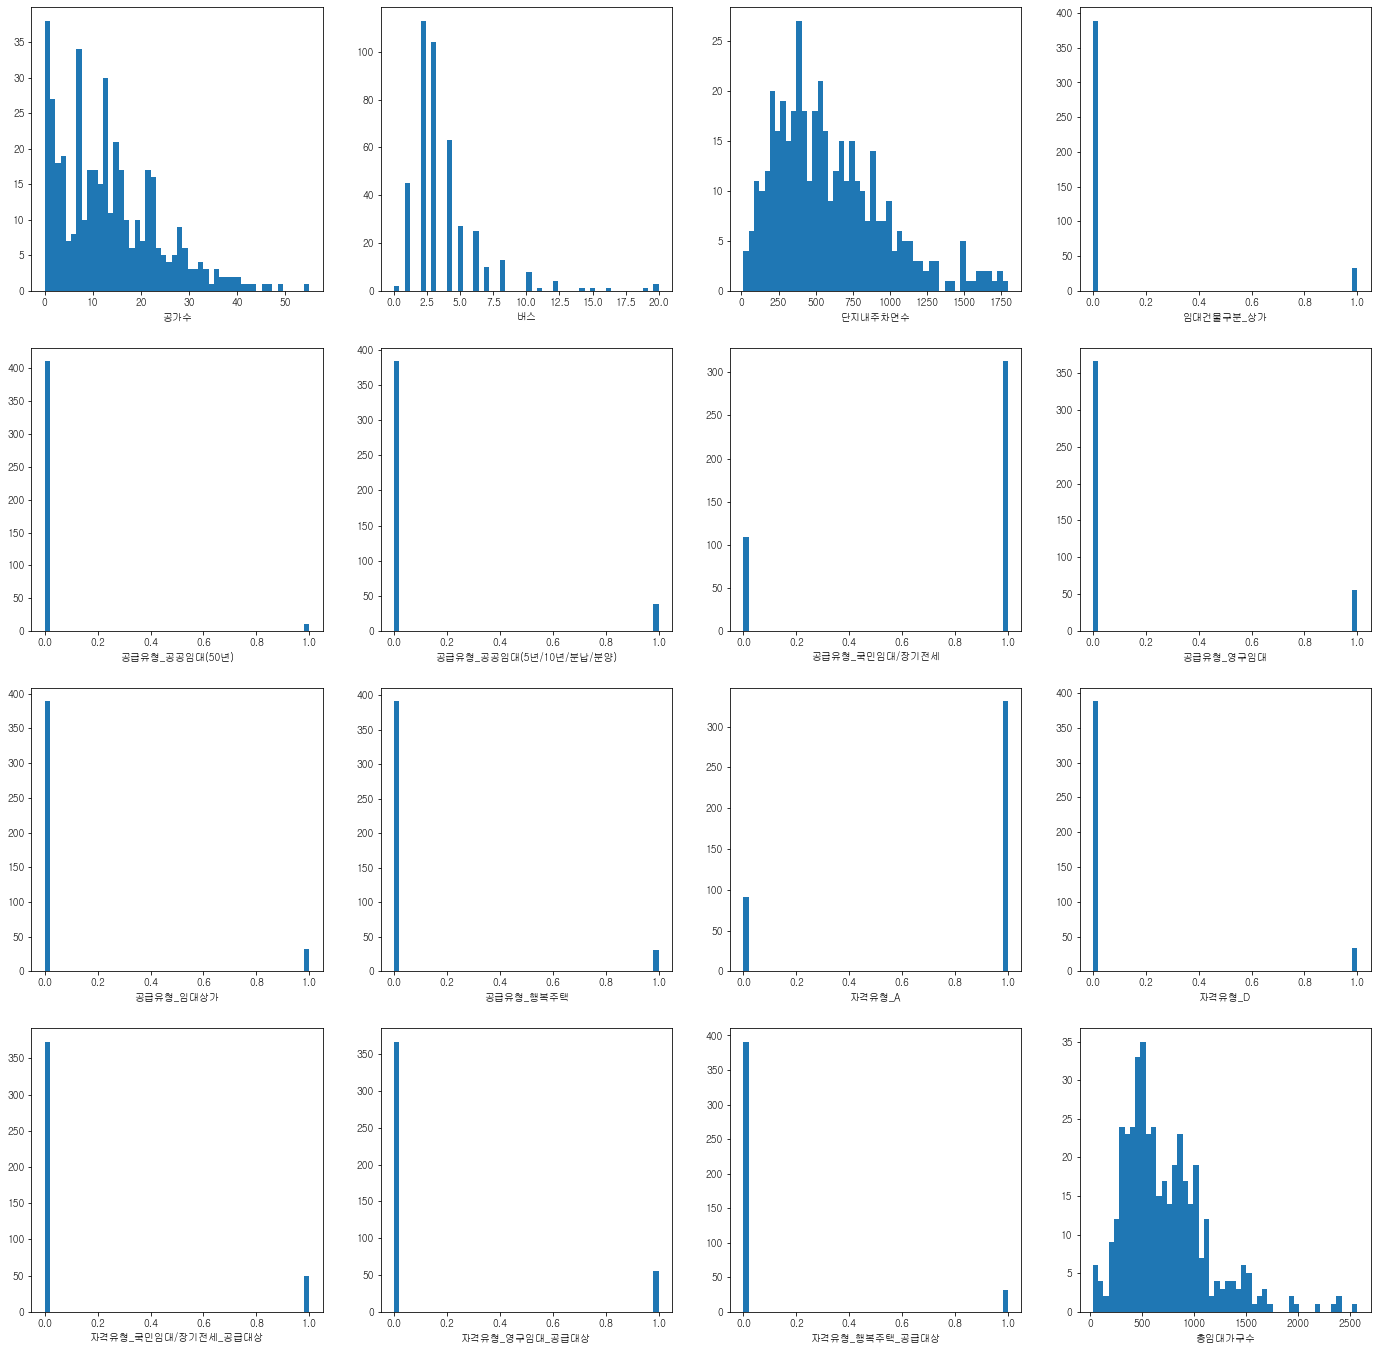

In [215]:
fig, ax = plt.subplots(4,4, figsize= (24,24))

i = 0
for f in scailing_features[:16]:
    c = i % 4
    r = i // 4
    
    ax[r,c].hist(x = f, bins =50, data = X_train)
    ax[r,c].set_xlabel(f)
    i += 1
plt.show()

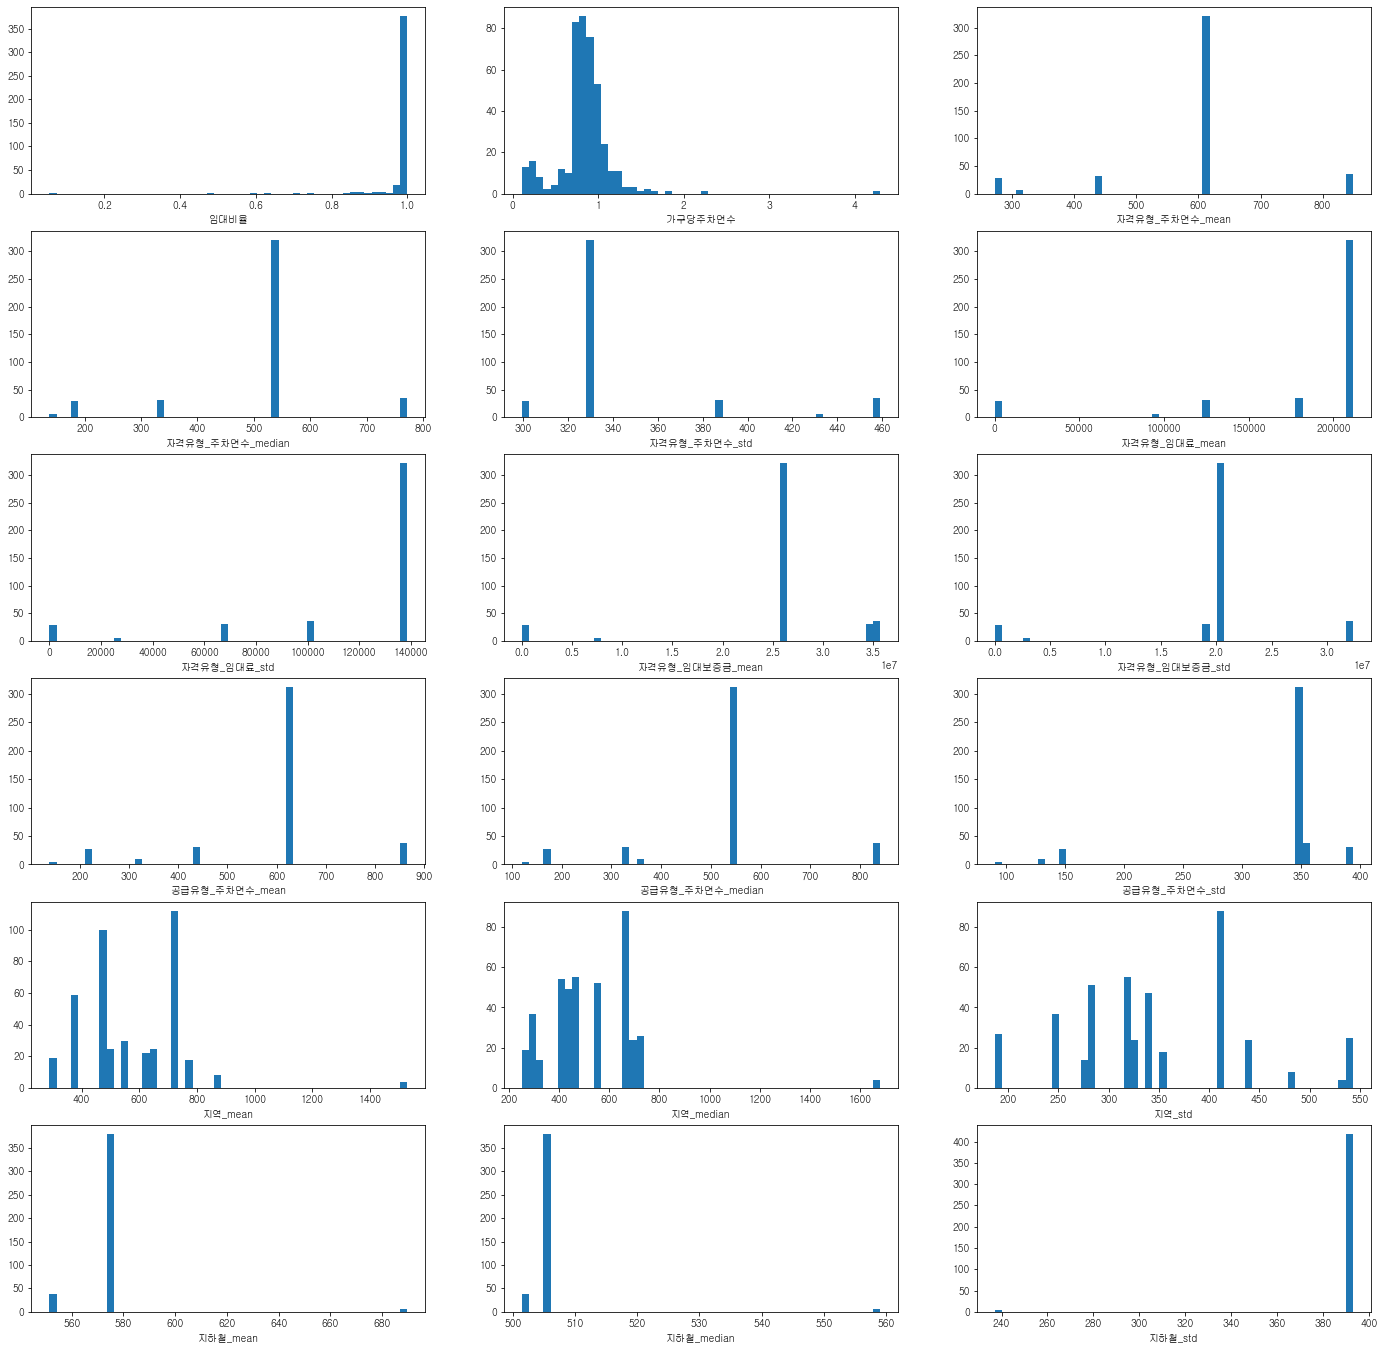

In [216]:
fig, ax = plt.subplots(6,3, figsize= (24,24))

i = 0
for f in scailing_features[16:]:
    c = i % 3
    r = i // 3
    
    ax[r,c].hist(x = f, bins =50, data = X_train)
    ax[r,c].set_xlabel(f)
    i += 1
plt.show()

In [217]:
# 지하철 std는 그림상 의미가 없기에 Drop
X_train = X_train.drop(['지하철_std'], axis=1)
X_test = X_test.drop(['지하철_std'], axis=1)

In [218]:
# 지역은  Scailing

scaler = RobustScaler() # 이상치에 좋다.
loc_f = [# '자격유형_주차면수_mean',
         # '자격유형_주차면수_median',
         # '자격유형_주차면수_std',
         # '자격유형_임대료_mean',
         # '자격유형_임대료_std',
         # '자격유형_임대보증금_mean',
         # '자격유형_임대보증금_std',
         # '공급유형_주차면수_mean',
         # '공급유형_주차면수_median',
         # '공급유형_주차면수_std',         
        '지역_mean', 
        '지역_median',
        '지역_std',
]
X_train.loc[:, loc_f] = scaler.fit_transform(X_train[loc_f])
X_test.loc[:, loc_f] = scaler.transform(X_test[loc_f])

In [219]:
X_train[['자격유형_임대료_median', '자격유형_임대료_mean']] = X_train[['자격유형_임대료_median', '자격유형_임대료_mean']].astype('int64')
X_test[['자격유형_임대료_median', '자격유형_임대료_mean']] = X_test[['자격유형_임대료_median', '자격유형_임대료_mean']].astype('int64')

In [220]:
# 나머지 Scailing (연속형 변수들)
scailing_features = ['총세대수', '공가수', '버스', '단지내주차면수','총임대가구수',
       '임대비율', '가구당주차면수', '자격유형_주차면수_mean', '자격유형_주차면수_median', '자격유형_주차면수_std',
       '자격유형_임대료_mean', '자격유형_임대료_median', '자격유형_임대료_std', '자격유형_임대보증금_mean',
       '자격유형_임대보증금_median', '자격유형_임대보증금_std', '공급유형_주차면수_mean',
       '공급유형_주차면수_median', '공급유형_주차면수_std', '세대수', '자가용', '지하철_mean', '지하철_median']

scaler = StandardScaler()
X_train.loc[:, scailing_features] = scaler.fit_transform(X_train[scailing_features])
X_test.loc[:, scailing_features] = scaler.transform(X_test[scailing_features])

In [221]:
X_train.index = X_train['단지코드']
X_test.index = X_test['단지코드']

X_train.drop(['단지코드'], axis=1, inplace=True)
X_test.drop(['단지코드'], axis=1, inplace=True)

# 모델 검정 및 최적화

In [222]:
X = X_train.drop(['등록차량수'], axis=1)
y = X_train['등록차량수']

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1127)
folds = []

for tr_idx, val_idx in skf.split(X,y):
    folds.append((tr_idx, val_idx))

len(folds)

5

In [223]:
def objective(trial: Trial) -> float:
    params_cat = {
        "random_state": 42,
        "learning_rate": 0.05,
        "n_estimators": 10000,
        "verbose" : 1,
        "objective" : "MAE",
        "max_depth": trial.suggest_int("max_depth", 1, 16),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.8, 1.0),
        "subsample": trial.suggest_float("subsample", 0.3, 1.0),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "max_bin": trial.suggest_int("max_bin", 200, 500),
    }
    
    X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.2)

    model = CatBoostRegressor(**params_cat)
    model.fit(
        X_tr,
        y_tr,
        eval_set=[(X_tr, y_tr), (X_val, y_val)],
        early_stopping_rounds=10,
        verbose=False,
    )

    cat_pred = model.predict(X_val)
    log_score = mean_absolute_error(y_val, cat_pred)
    
    return log_score

In [224]:
# 현재 Best Score : 102.65666223331039

sampler = TPESampler(seed=1127)
study = optuna.create_study(
    study_name="cat_opt",
    direction="minimize",
    sampler=sampler,
)
study.optimize(objective, n_trials=10)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2021-08-05 17:58:18,825] A new study created in memory with name: cat_opt
[I 2021-08-05 17:58:19,150] Trial 0 finished with value: 131.32643768564031 and parameters: {'max_depth': 1, 'colsample_bylevel': 0.9277536172072297, 'subsample': 0.37775326490136574, 'min_child_samples': 6, 'max_bin': 286}. Best is trial 0 with value: 131.32643768564031.
[I 2021-08-05 17:58:20,294] Trial 1 finished with value: 104.91634549954375 and parameters: {'max_depth': 10, 'colsample_bylevel': 0.9632268615144101, 'subsample': 0.7105927076225801, 'min_child_samples': 15, 'max_bin': 247}. Best is trial 1 with value: 104.91634549954375.
[I 2021-08-05 17:58:20,652] Trial 2 finished with value: 99.87262943868885 and parameters: {'max_depth': 3, 'colsample_bylevel': 0.8821010228355666, 'subsample': 0.7809309730258094, 'min_child_samples': 33, 'max_bin': 466}. Best is trial 2 with value: 99.87262943868885.
[I 2021-08-05 17:59:02,213] Trial 3 finished with value: 163.04988287025284 and parameters: {'max_depth':

Best Score: 99.87262943868885
Best trial: {'max_depth': 3, 'colsample_bylevel': 0.8821010228355666, 'subsample': 0.7809309730258094, 'min_child_samples': 33, 'max_bin': 466}


In [225]:
# 기준 CV MAE : 132.61625260436796
# 기준 MAPE : 124.0791060383534
cat_p = study.best_trial.params
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1127)
folds = []

for tr_idx, val_idx in skf.split(X,y):
    folds.append((tr_idx, val_idx))

y_oof = np.zeros(X.shape[0])
y_preds = np.zeros(X_test.shape[0])
cat_p = study.best_trial.params

for fold in range(len(folds)):
    print(f'==========={fold}===========')
    tr_idx, val_idx = folds[fold]
    
    X_tr, X_val, y_tr, y_val = X.iloc[tr_idx], X.iloc[val_idx], y.iloc[tr_idx], y.iloc[val_idx]
    cat = CatBoostRegressor(**cat_p)
    cat.fit(X_tr, y_tr, eval_set=(X_val, y_val), early_stopping_rounds=100, verbose = 500)
    
    y_pred_valid = cat.predict(X_val)
    y_oof[val_idx] = y_pred_valid
    y_preds += cat.predict(X_test) / 5
    print(f'CV MAE Score: {mean_absolute_error(y_val, y_pred_valid)}')
    
print(f'MAE Score: {mean_absolute_error(y, y_oof)}')

===========0===========
Learning rate set to 0.037515
0:	learn: 386.6954320	test: 375.9470589	best: 375.9470589 (0)	total: 1.28ms	remaining: 1.28s
500:	learn: 100.5892676	test: 153.2226150	best: 153.2226150 (500)	total: 545ms	remaining: 543ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 151.0896956
bestIteration = 613

Shrink model to first 614 iterations.
CV MAE Score: 111.0428778636249
===========1===========
Learning rate set to 0.037515
0:	learn: 386.7936198	test: 374.2995434	best: 374.2995434 (0)	total: 933us	remaining: 933ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 159.1936561
bestIteration = 254

Shrink model to first 255 iterations.
CV MAE Score: 118.34926487259686
===========2===========
Learning rate set to 0.037536
0:	learn: 373.5499454	test: 427.5151058	best: 427.5151058 (0)	total: 994us	remaining: 994ms
500:	learn: 101.1541737	test: 212.4473261	best: 212.4473261 (500)	total: 442ms	remaining: 441ms
Stopped by overfitting detec

In [226]:
cat_p = study.best_trial.params
cat = CatBoostRegressor(**cat_p)

# 예측 및 제출

In [227]:
y_cat = pd.cut(y, 10, labels=range(10))
skf = StratifiedKFold(16)

preds = [] # 예측 값

for tr_id, val_id in skf.split(X, y_cat):
    X_tr = X.iloc[tr_id]
    y_tr = y.iloc[tr_id]
    
    cat.fit(X_tr, y_tr, verbose = 0)
    pred = cat.predict(X_test)
    preds.append(pred)
    
cat_pred = np.mean(preds, axis = 0)
display(len(cat_pred))
cat_pred

150

array([ 738.8761894 , 1184.78357874,  513.20534421,  472.08620663,
       1100.84569685, 1876.87537387,  822.59308497,  439.45885111,
        307.13812385,  248.43439506,  391.24826963,  278.0255633 ,
        363.85555977,  183.43677399,  498.03370269,  239.07391436,
        424.36062402,  254.96191136,  109.42416381,  622.31170979,
        154.73857347,  429.31005101,  484.00392791,  443.99777062,
        378.15208169,  125.54719431,  142.98056695,  620.02580583,
        542.6264085 ,  496.91939626,  849.93774418,  132.44010528,
        457.89932215,  162.84844197,  123.92541358,  342.31068913,
        353.34139011,  590.82929804,  790.95472481,  323.52918571,
        373.35265253,  535.67024394,  452.59003701,  558.16081697,
        844.50311715, 1266.26046848,  432.6272923 ,  595.12758072,
        407.73429427,  317.5547174 ,  711.68131374,  247.95540004,
       1076.53859855,  589.91414487,  572.56338937,  273.40219804,
        618.79373678,  219.50846444,  454.59766323,  206.42408

In [228]:
submission['num'] = cat_pred
submission.to_csv('submission/cb_0805.csv', index=False)

# 변수 중요도 확인 및 변수 선택

In [229]:
def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

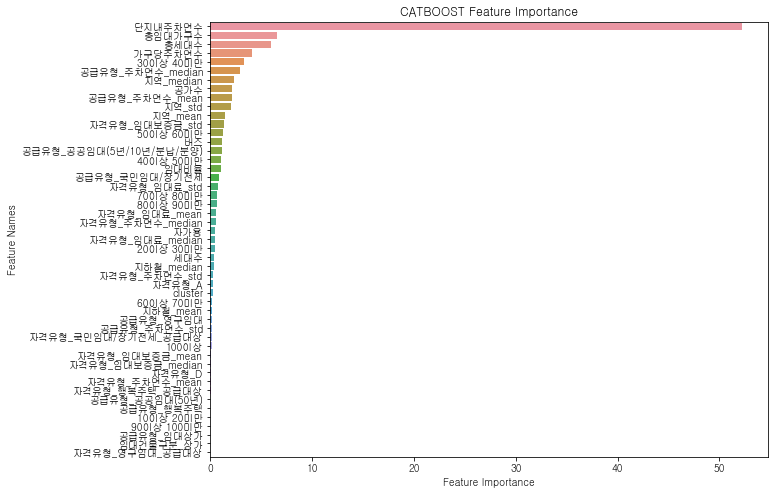

In [230]:
plot_feature_importance(cat.get_feature_importance(),X.columns,'CATBOOST')

In [231]:
imp_df = pd.DataFrame({'feature_names':cat.feature_names_,'feature_importance':cat.feature_importances_})
imp_df = imp_df.sort_values(by='feature_importance', ascending=False)

# 상위 75%까지의 변수들만 추출해서 사용
imp_feat = imp_df['feature_names'].to_list()[:int(imp_df.shape[0]*0.75)]

X = X.loc[:, imp_feat]
X_test = X_test.loc[:, imp_feat]

In [232]:
def objective(trial: Trial) -> float:
    params_cat = {
        "random_state": 42,
        "learning_rate": 0.05,
        "n_estimators": 10000,
        "verbose" : 1,
        "objective" : "MAE",
        "max_depth": trial.suggest_int("max_depth", 1, 16),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.8, 1.0),
        "subsample": trial.suggest_float("subsample", 0.3, 1.0),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "max_bin": trial.suggest_int("max_bin", 200, 500),
    }
    
    X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.2)

    model = CatBoostRegressor(**params_cat)
    model.fit(
        X_tr,
        y_tr,
        eval_set=[(X_tr, y_tr), (X_val, y_val)],
        early_stopping_rounds=10,
        verbose=False,
    )

    cat_pred = model.predict(X_val)
    log_score = mean_absolute_error(y_val, cat_pred)
    
    return log_score

In [233]:
# 현재 Best Score : 102.65666223331039

sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name="cat_opt",
    direction="minimize",
    sampler=sampler,
)
study.optimize(objective, n_trials=10)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2021-08-05 17:59:29,740] A new study created in memory with name: cat_opt
[I 2021-08-05 17:59:30,145] Trial 0 finished with value: 119.03926853930686 and parameters: {'max_depth': 6, 'colsample_bylevel': 0.9901428612819833, 'subsample': 0.8123957592679836, 'min_child_samples': 62, 'max_bin': 246}. Best is trial 0 with value: 119.03926853930686.
[I 2021-08-05 17:59:30,393] Trial 1 finished with value: 113.9949535434336 and parameters: {'max_depth': 3, 'colsample_bylevel': 0.8116167224336399, 'subsample': 0.9063233020424546, 'min_child_samples': 62, 'max_bin': 413}. Best is trial 1 with value: 113.9949535434336.
[I 2021-08-05 17:59:30,559] Trial 2 finished with value: 118.9686901715904 and parameters: {'max_depth': 1, 'colsample_bylevel': 0.9939819704323989, 'subsample': 0.8827098485602951, 'min_child_samples': 25, 'max_bin': 254}. Best is trial 1 with value: 113.9949535434336.
[I 2021-08-05 17:59:30,829] Trial 3 finished with value: 129.84720480356367 and parameters: {'max_depth': 3,

Best Score: 113.89880989361319
Best trial: {'max_depth': 2, 'colsample_bylevel': 0.8990353820222541, 'subsample': 0.32407196478065287, 'min_child_samples': 92, 'max_bin': 277}


In [234]:
# 기준 CV MAE : 132.61625260436796
# 기준 MAPE : 124.0791060383534
cat_p = study.best_trial.params
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1127)
folds = []

for tr_idx, val_idx in skf.split(X,y):
    folds.append((tr_idx, val_idx))

y_oof = np.zeros(X.shape[0])
y_preds = np.zeros(X_test.shape[0])
cat_p = study.best_trial.params

for fold in range(len(folds)):
    print(f'==========={fold}===========')
    tr_idx, val_idx = folds[fold]
    
    X_train, X_valid, y_train, y_valid = X.iloc[tr_idx], X.iloc[val_idx], y.iloc[tr_idx], y.iloc[val_idx]
    cat = CatBoostRegressor(**cat_p)
    cat.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stopping_rounds=100, verbose = 500)
    
    y_pred_valid = cat.predict(X_valid)
    y_oof[val_idx] = y_pred_valid
    y_preds += cat.predict(X_test) / 5
    print(f'CV MAE Score: {mean_absolute_error(y_valid, y_pred_valid)}')
    
print(f'MAE Score: {mean_absolute_error(y, y_oof)}')

===========0===========
Learning rate set to 0.037515
0:	learn: 384.4728216	test: 375.3755337	best: 375.3755337 (0)	total: 1.72ms	remaining: 1.72s
500:	learn: 126.2725384	test: 161.5611181	best: 161.4408753 (401)	total: 238ms	remaining: 237ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 161.4408753
bestIteration = 401

Shrink model to first 402 iterations.
CV MAE Score: 120.21739936929713
===========1===========
Learning rate set to 0.037515
0:	learn: 385.6677215	test: 372.6536839	best: 372.6536839 (0)	total: 2.19ms	remaining: 2.19s
500:	learn: 128.6368591	test: 154.8452226	best: 154.8090821 (499)	total: 412ms	remaining: 410ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 152.3871349
bestIteration = 719

Shrink model to first 720 iterations.
CV MAE Score: 111.22620031556467
===========2===========
Learning rate set to 0.037536
0:	learn: 372.5614397	test: 426.6164681	best: 426.6164681 (0)	total: 729us	remaining: 729ms
500:	learn: 128.4024848	te

In [235]:
cat_p = study.best_trial.params
cat = CatBoostRegressor(**cat_p)

In [236]:
y_cat = pd.cut(y, 10, labels=range(10))
skf = StratifiedKFold(16)

preds = [] # 예측 값

for tr_id, val_id in skf.split(X, y_cat):
    X_tr = X.iloc[tr_id]
    y_tr = y.iloc[tr_id]
    
    cat.fit(X_tr, y_tr, verbose = 0)
    pred = cat.predict(X_test)
    preds.append(pred)
    
cat_pred_selected = np.mean(preds, axis = 0)
display(len(cat_pred))
cat_pred_selected

150

array([ 706.03281688, 1177.09021166,  551.90171486,  481.76329246,
       1065.66427435, 1909.03006332,  835.15522646,  422.54917966,
        298.53031954,  234.07472043,  367.09790458,  215.91871184,
        346.83838022,  102.809737  ,  403.68944552,  232.65225588,
        425.32474493,  251.16128916,  121.65898292,  651.8636137 ,
        197.03073742,  416.13839463,  445.91525336,  448.87447984,
        371.35568549,  151.30046836,  152.02615365,  601.38405158,
        536.82848575,  472.31594616,  844.58997511,  134.88231158,
        446.63788008,  107.31036139,  100.46284213,  326.92834849,
        365.26854204,  606.52937499,  814.22742802,  322.00137216,
        393.56979577,  517.59378539,  419.24439735,  550.70303578,
        842.16367985, 1244.06986485,  427.97209485,  612.21963748,
        423.02269542,  312.5242235 ,  776.24877755,  242.16090237,
       1039.32049519,  570.08744544,  548.49612589,  277.13688945,
        611.40463351,  211.78767375,  453.36436478,  221.59675

In [237]:
# 제출 양식
submission = pd.read_csv('sample_submission.csv')
submission['num'] = cat_pred_selected
submission.to_csv('submission/cb0805_selected.csv', index=False)